In [ ]:
from selenium.webdriver.chrome.service import Service
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from datetime import datetime, timedelta, time as datetime_time
import time
import pytz
import csv
import random
from urllib.parse import quote
from webdriver_manager.chrome import ChromeDriverManager
from dotenv import load_dotenv
import os
from constants import SANREMO

# Load environment variables
load_dotenv()


class TwitterScraper:

    credentials = {
        "username": os.getenv("TWITTER_USERNAME"),
        "password": os.getenv("TWITTER_PASSWORD"),
    }
    if not all(credentials.values()):
        raise ValueError("Missing Twitter credentials in .env file")

    def __init__(self, headless=True):
        self.options = webdriver.ChromeOptions()
        if headless:
            self.options.add_argument("--headless=new")
        self.options.add_argument("--disable-blink-features=AutomationControlled")
        self.options.add_argument("--disable-dev-shm-usage")
        self.options.add_argument("--no-sandbox")
        self.options.add_argument("--window-size=1920,1080")
        self.options.add_argument(
            "--user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36"
        )

        self.driver = webdriver.Chrome(
            service=Service(ChromeDriverManager().install()), options=self.options
        )

        self.rome_tz = pytz.timezone("Europe/Rome")
        self.logged_in = False

    def login(self, username, password):
        print("Attempting login...")
        self.driver.get("https://twitter.com/login")
        time.sleep(random.uniform(1, 3))

        try:
            # Handle username
            username_field = WebDriverWait(self.driver, 15).until(
                EC.presence_of_element_located(
                    (By.XPATH, '//input[@autocomplete="username"]')
                )
            )
            username_field.send_keys(username)
            self.click_element("//span[text()='Avanti' or text()='Next']")

            # Handle password
            password_field = WebDriverWait(self.driver, 15).until(
                EC.presence_of_element_located(
                    (By.XPATH, '//input[@autocomplete="current-password"]')
                )
            )
            password_field.send_keys(password)
            self.click_element("//span[text()='Accedi' or text()='Log in']")

            # Wait for login to complete
            WebDriverWait(self.driver, 15).until(
                EC.presence_of_element_located((By.XPATH, "//a[@href='/home']"))
            )
            self.logged_in = True
            print("Login successful")
            time.sleep(random.uniform(2, 4))

        except Exception as e:
            print(f"Login failed: {str(e)}")
            raise Exception("Login required for scraping")

    def click_element(self, xpath):
        element = WebDriverWait(self.driver, 15).until(
            EC.element_to_be_clickable((By.XPATH, xpath))
        )
        self.driver.execute_script("arguments[0].click();", element)

    def scrape_tweets(self, artist, start_datetime, end_datetime, max_tweets=500, near_you=False):
        print(
            f"Scraping tweets for {artist} between {start_datetime} and {end_datetime}..."
        )
        if not self.logged_in:
            self.login(self.credentials["username"], self.credentials["password"])

        # Convert to UTC
        start_utc = start_datetime.astimezone(pytz.utc)
        end_utc = end_datetime.astimezone(pytz.utc)

        # Format dates for Twitter search
        since_date = start_datetime.strftime("%Y-%m-%d")
        until_date = end_datetime.strftime("%Y-%m-%d")

        # Build search URL
        query = f'"{artist}" since:{since_date} until:{until_date}'
        url = f"https://twitter.com/search?q={quote(query)}&src=typed_query"

        if near_you:
            url += "&lf=on"

        print(f"\nQuerying URL: {url}")

        self.driver.get(url)
        time.sleep(random.uniform(2, 5))

        tweets_data = []
        try:
            # Wait strategy
            WebDriverWait(self.driver, 20).until(
                EC.presence_of_element_located(
                    (By.XPATH, '//article[.//div[@data-testid="User-Name"]]')
                )
            )

            # Scroll and load tweets
            last_height = self.driver.execute_script(
                "return document.body.scrollHeight"
            )
            scroll_attempts = 0

            while scroll_attempts < 15 and len(tweets_data) < max_tweets:
                # Find all tweet elements using modern selectors
                tweets = self.driver.find_elements(
                    By.XPATH, '//article[.//div[@data-testid="User-Name"]]'
                )

                for tweet in tweets:
                    if len(tweets_data) >= max_tweets:
                        break

                    try:
                        # Get timestamp
                        time_element = tweet.find_element(By.XPATH, ".//time")
                        tweet_datetime_utc = datetime.fromisoformat(
                            time_element.get_attribute("datetime").replace(
                                "Z", "+00:00"
                            )
                        )

                        # Convert to Italy time
                        tweet_datetime_rome = tweet_datetime_utc.astimezone(
                            self.rome_tz
                        )

                        # Check if within time window
                        if start_utc <= tweet_datetime_utc <= end_utc:
                            # Get content
                            content = tweet.find_element(
                                By.XPATH, './/div[@data-testid="tweetText"]'
                            ).text

                            tweets_data.append(
                                {
                                    "artist": artist,
                                    "datetime": tweet_datetime_rome,
                                    "content": content,
                                }
                            )

                    except Exception as e:
                        continue

                # Scroll down with random behavior
                self.driver.execute_script(
                    "window.scrollTo(0, document.body.scrollHeight);"
                )
                time.sleep(random.uniform(1.8, 4.2))
                new_height = self.driver.execute_script(
                    "return document.body.scrollHeight"
                )

                if new_height == last_height:
                    scroll_attempts += 1
                else:
                    scroll_attempts = 0
                last_height = new_height

        except Exception as e:
            print(f"Error during scraping: {str(e)}")

        # finally:
        #     self.driver.quit()

        return tweets_data

    def save_to_csv(self, data, filename):
        with open(filename, "w", newline="", encoding="utf-8") as file:
            writer = csv.DictWriter(file, fieldnames=["artist", "datetime", "content"])
            writer.writeheader()
            for row in data:
                writer.writerow(
                    {
                        "artist": row["artist"],
                        "datetime": row["datetime"].strftime("%Y-%m-%d %H:%M:%S"),
                        "content": row["content"],
                    }
                )

    def scrape_every_night(self):
        try:
            os.makedirs("scraped_data", exist_ok=True)
            folder_name = "scraped_data"
            for night_name, night_info in SANREMO["NIGHTS"].items():
                artists = night_info["scaletta"]
                night_date = datetime.strptime(night_info["data"], "%Y-%m-%d").date()

                # Create folder for each night
                night_folder = folder_name + "/" + os.path.join(night_name.replace(" ", "_"))
                os.makedirs(night_folder, exist_ok=True)

                # Create aware datetime objects for night start/end
                start_night_time = self.rome_tz.localize(
                    datetime.combine(night_date, datetime_time(21, 0))
                )
                end_night_time = self.rome_tz.localize(
                    datetime.combine(
                        night_date + timedelta(days=1), datetime_time(1, 0)
                    )
                )

                for artist in artists:
                    artist_folder = os.path.join(night_folder, artist.replace(" ", "_"))
                    os.makedirs(artist_folder, exist_ok=True)

                    print(f"\nScraping tweets for {artist} on {night_name}")
                    tweets = self.scrape_tweets(
                        artist, start_night_time, end_night_time, max_tweets=500, near_you=False
                    )
                    print(f"Found {len(tweets)} total tweets")
                    
                    # Remove Duplicates
                    tweets = [dict(t) for t in {tuple(d.items()) for d in tweets}]
                    print(f"Found {len(tweets)} unique tweets")

                    # Save file with all tweets
                    filename = f"{night_date.strftime('%Y-%m-%d')}_all.csv"
                    filepath = os.path.join(artist_folder, filename)
                    self.save_to_csv(tweets, filepath)
                    print(f"Saved {len(tweets)} tweets to {filename}")

                    # Process hourly intervals
                    for hour in range(21, 25):  # 21-24 hours (9PM-12AM)
                        start_hour = hour % 24
                        end_hour = (hour + 1) % 24

                        # Determine base date for this hour
                        if start_hour >= 21:
                            base_date = night_date
                        else:
                            base_date = night_date + timedelta(days=1)

                        # Create naive datetime objects
                        start_dt_naive = datetime.combine(
                            base_date, datetime_time(start_hour, 0)
                        )
                        end_dt_naive = datetime.combine(
                            base_date, datetime_time(end_hour, 0)
                        )

                        # Adjust for midnight crossover
                        if end_hour < start_hour:
                            end_dt_naive += timedelta(days=1)

                        # Localize to Rome timezone
                        start_dt = self.rome_tz.localize(start_dt_naive)
                        end_dt = self.rome_tz.localize(end_dt_naive)


                        # Filter tweets in time window
                        hourly_tweets = [
                            t for t in tweets if start_dt <= t["datetime"] < end_dt
                        ]

                        # Generate filename
                        filename = f"{start_dt.strftime('%Y-%m-%d_%H')}-{end_dt.strftime('%H')}.csv"
                        filepath = os.path.join(artist_folder, filename)
                        self.save_to_csv(hourly_tweets, filepath)
                        print(f"Saved {len(hourly_tweets)} tweets to {filename}")

                    # wait for a random time between 1 - 4 minutes
                    time.sleep(random.uniform(60, 240))

        finally:
            print("Finished scraping")
            self.driver.quit()

In [2]:
# Scrape every night
scraper = TwitterScraper(headless=False)

try:
    scraper.scrape_every_night()
    print(f"\nSuccessfully collected tweets")
except Exception as e:
    print(f"\nScraping failed: {str(e)}")


Scraping tweets for Irama on Terza serata
Scraping tweets for Irama between 2025-02-13 21:00:00+01:00 and 2025-02-14 01:00:00+01:00...
Attempting login...
Login successful

Querying URL: https://twitter.com/search?q=%22Irama%22%20since%3A2025-02-13%20until%3A2025-02-14&src=typed_query
Found 287 total tweets
Found 116 unique tweets
Saved 116 tweets to 2025-02-13_all.csv
Saved 0 tweets to 2025-02-13_21-22.csv
Saved 0 tweets to 2025-02-13_22-23.csv
Saved 60 tweets to 2025-02-13_23-00.csv
Saved 56 tweets to 2025-02-14_00-01.csv
Finished scraping

Successfully collected tweets


## Plot for the scraped tweets

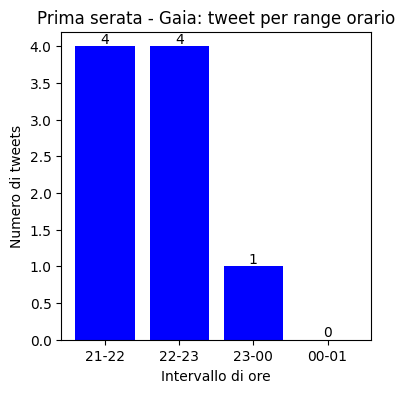

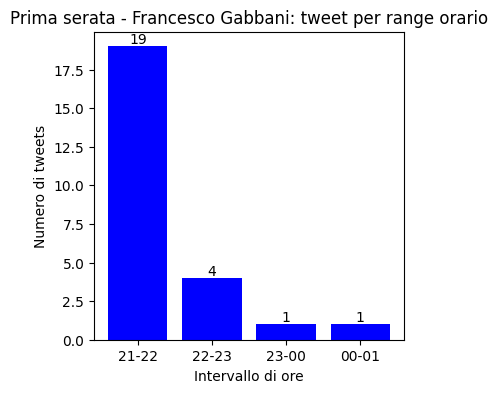

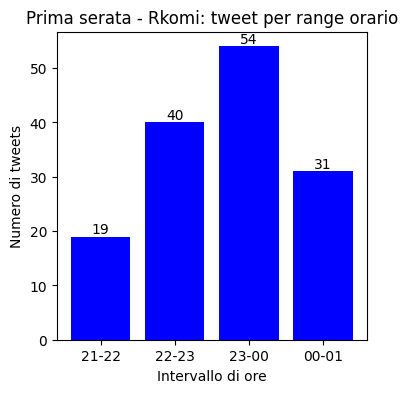

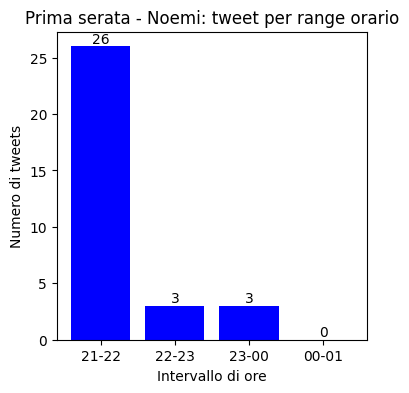

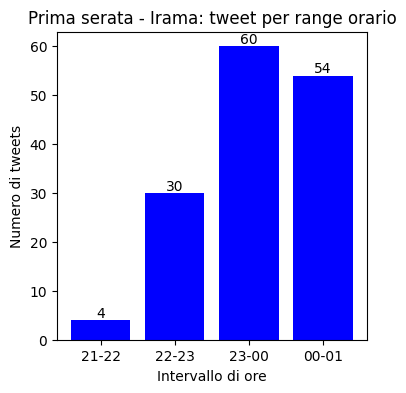

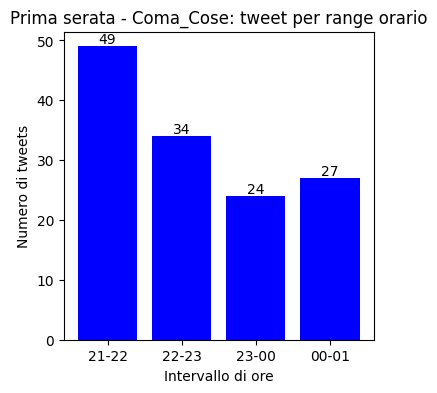

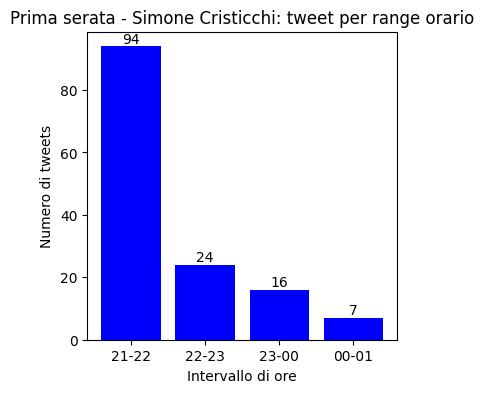

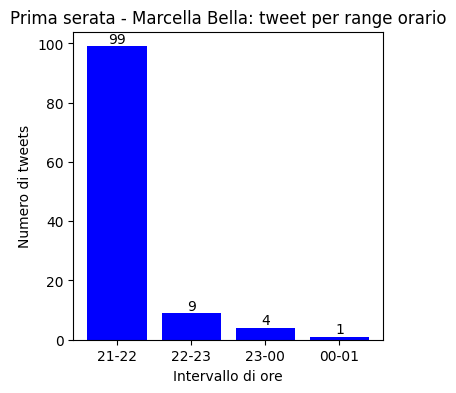

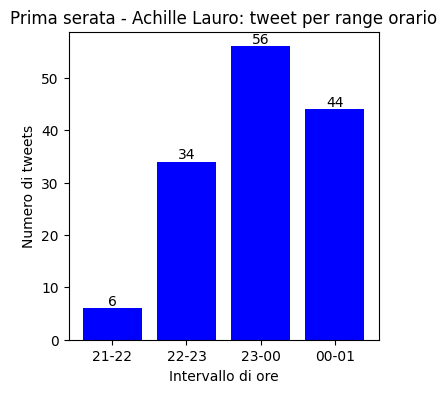

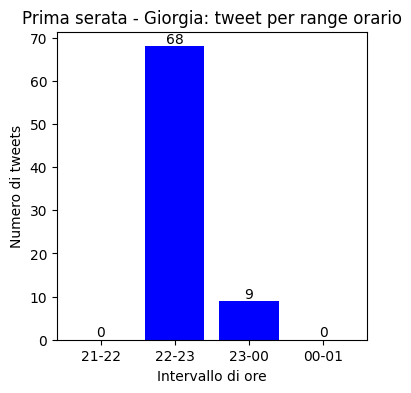

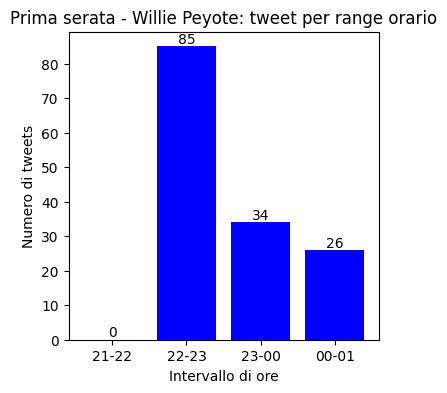

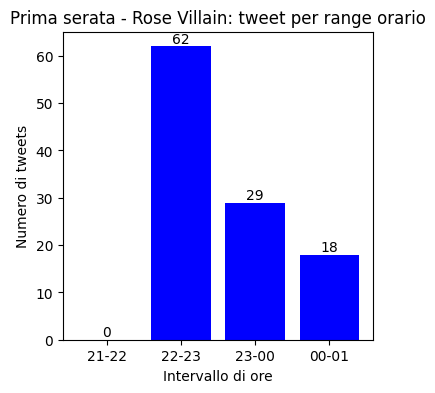

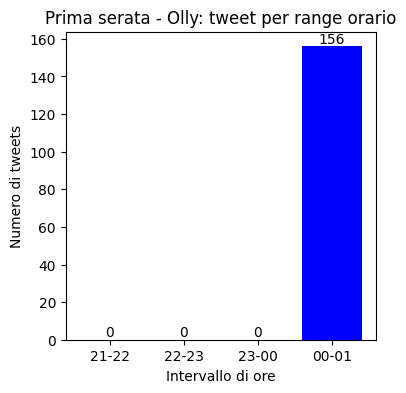

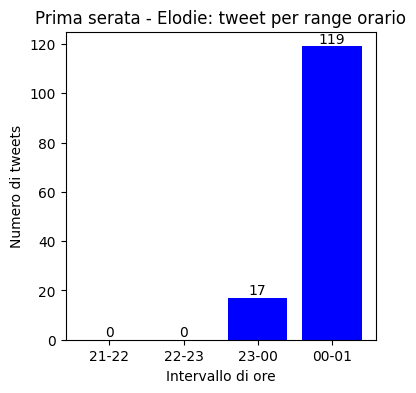

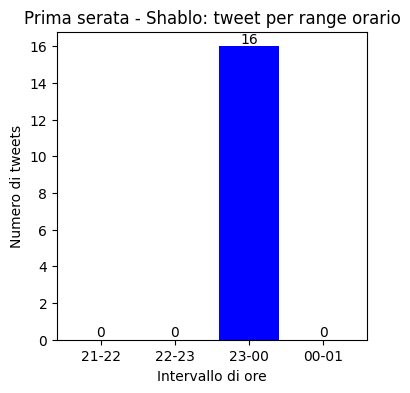

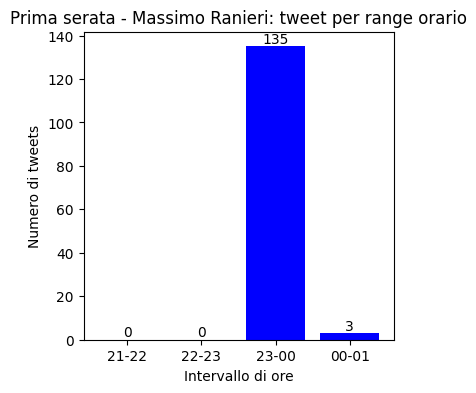

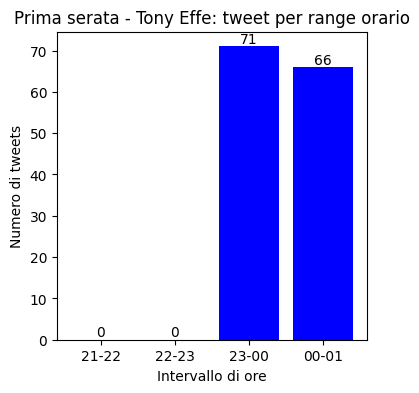

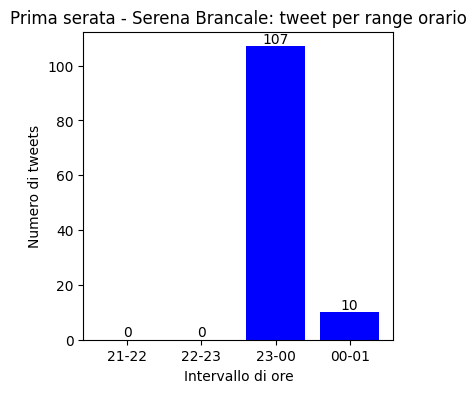

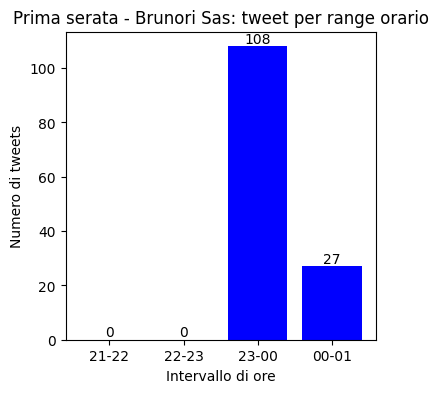

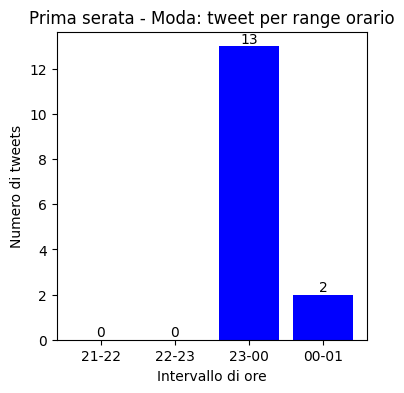

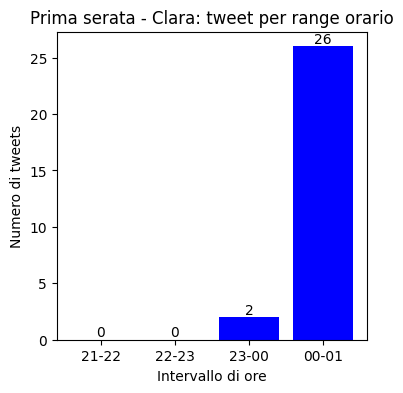

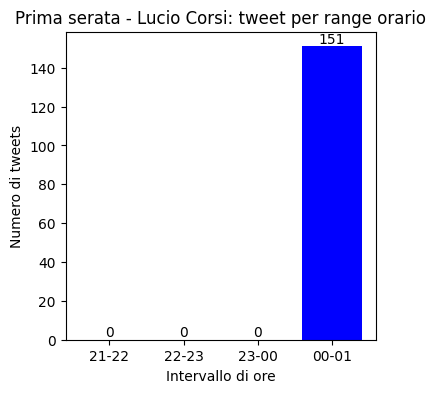

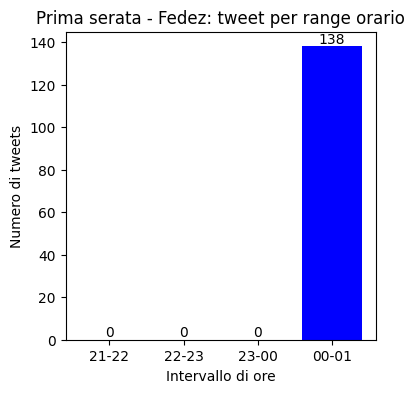

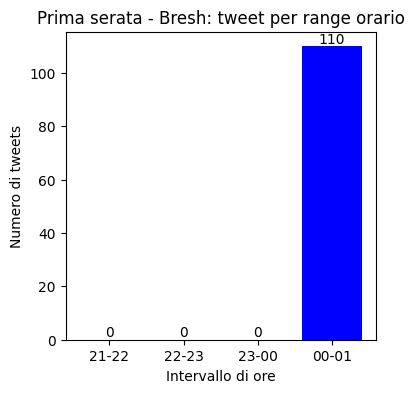

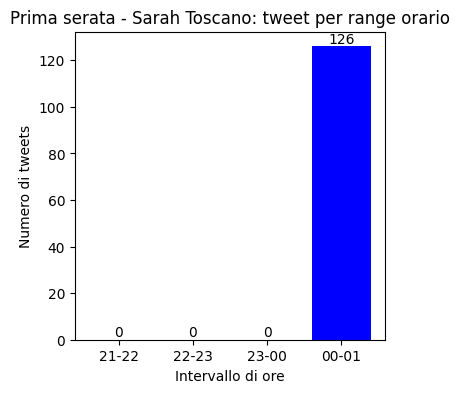

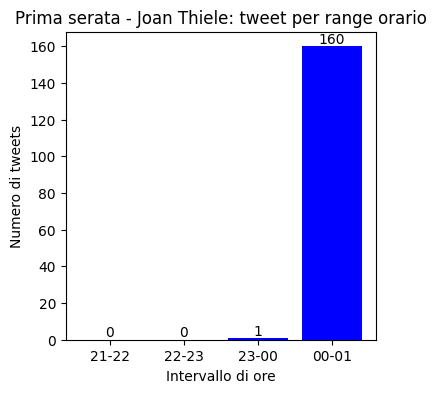

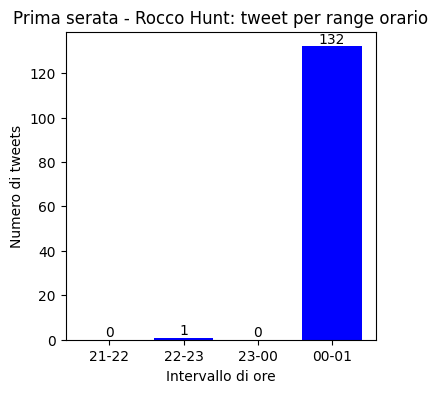

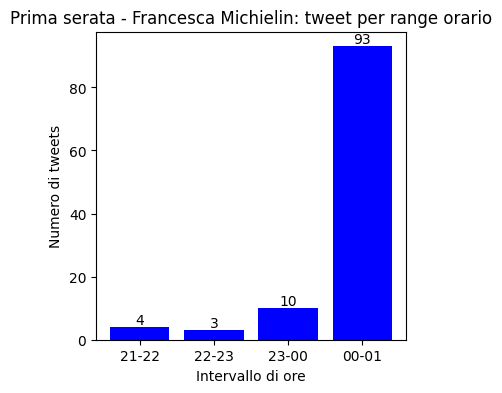

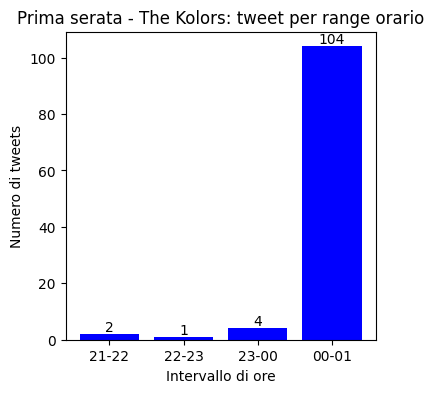

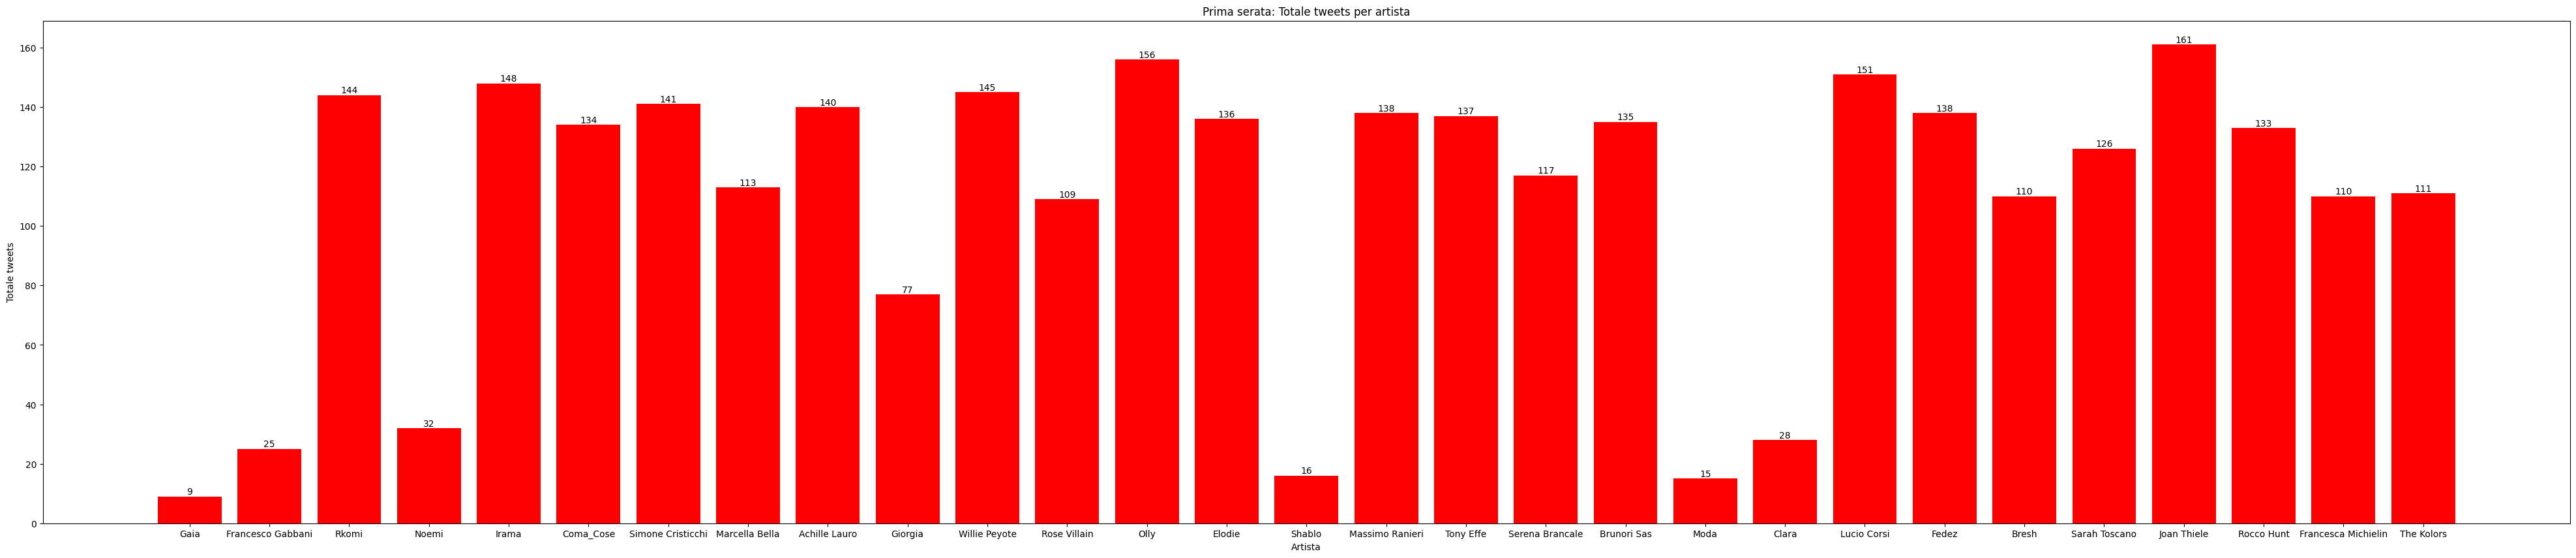

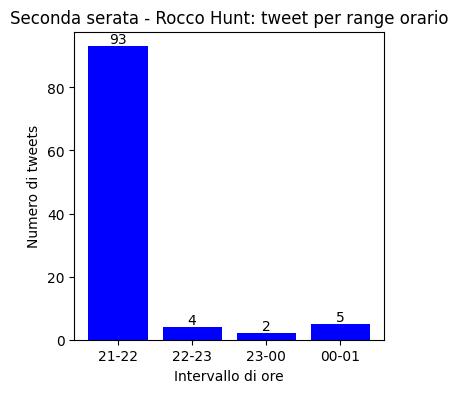

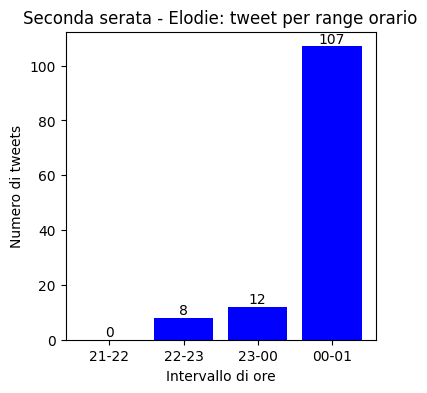

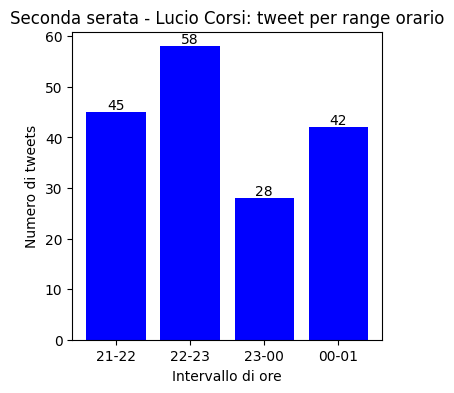

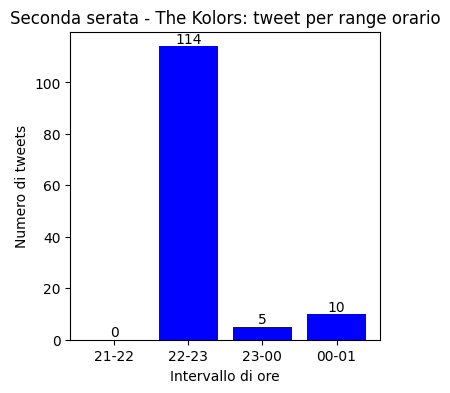

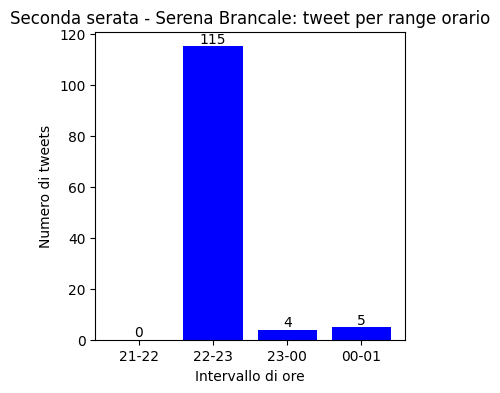

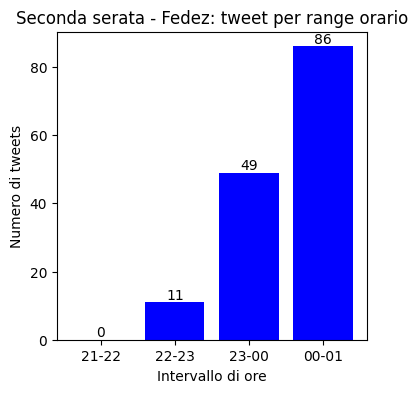

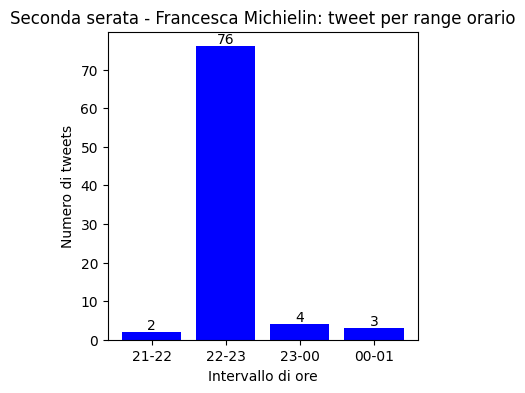

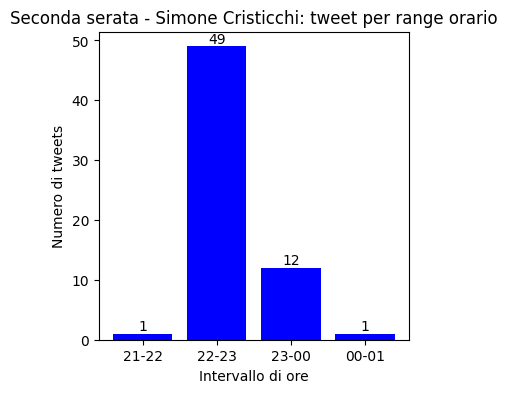

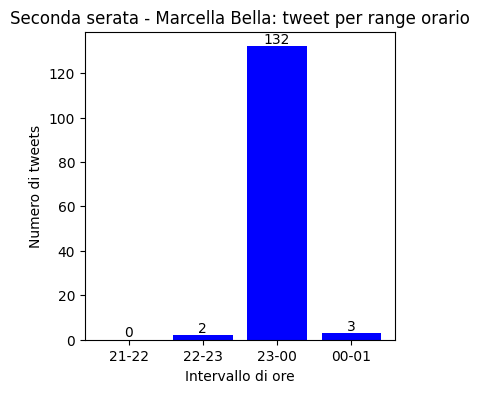

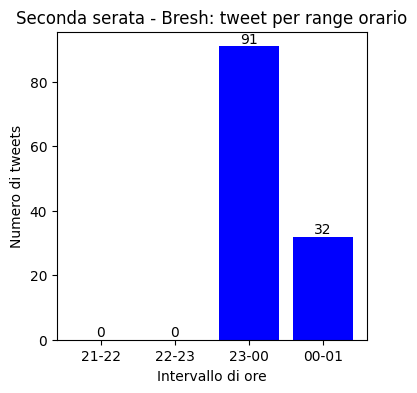

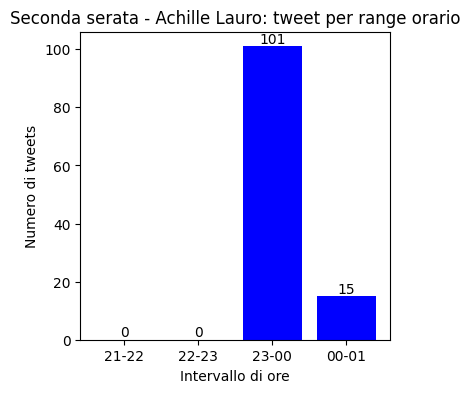

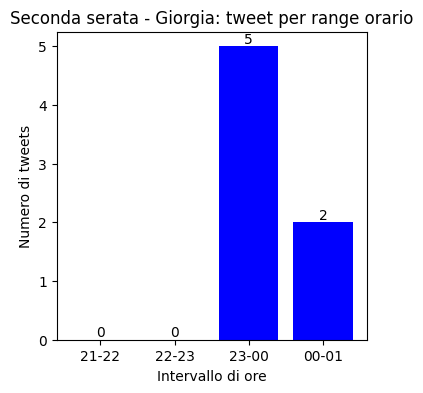

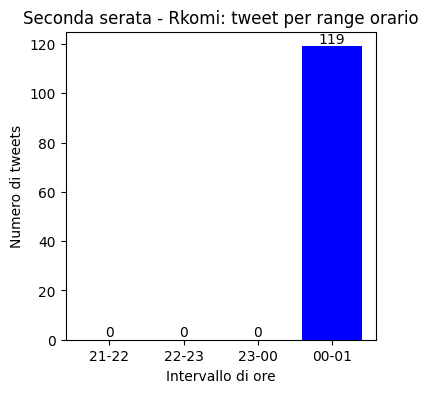

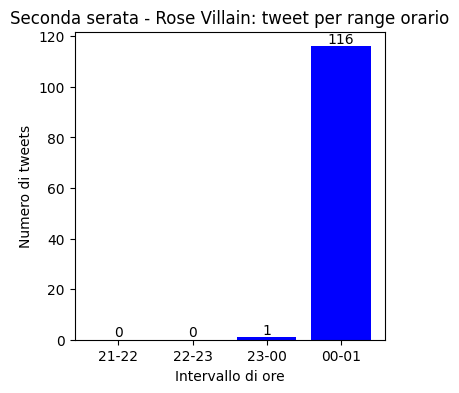

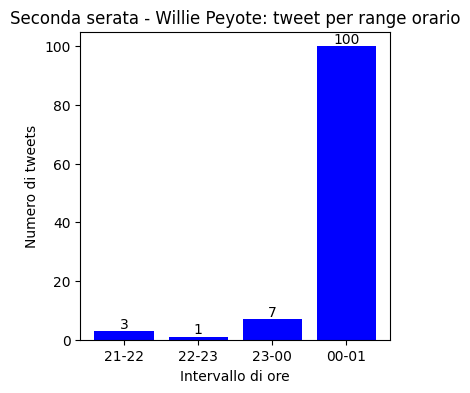

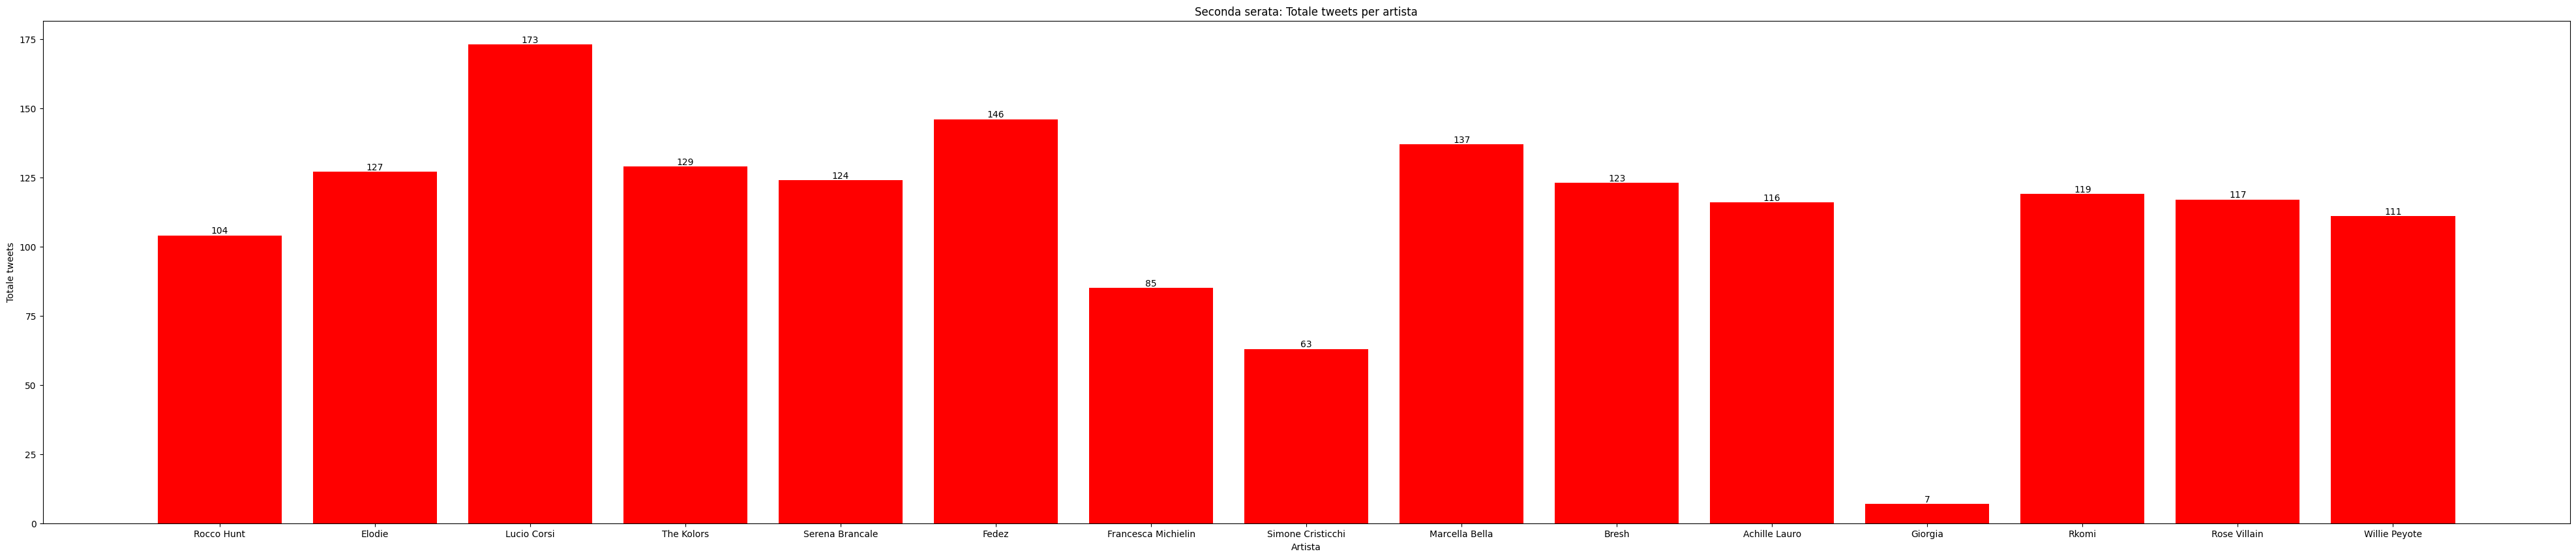

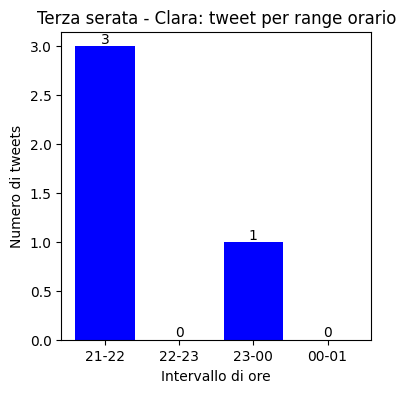

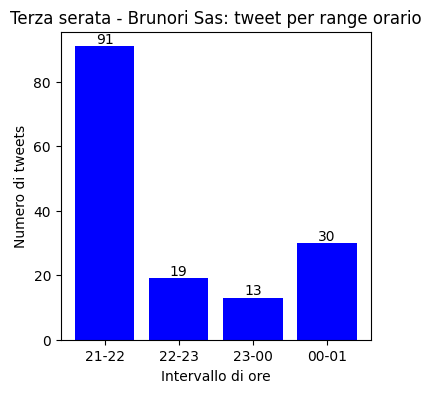

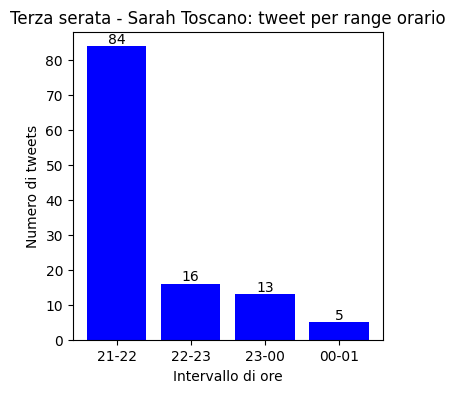

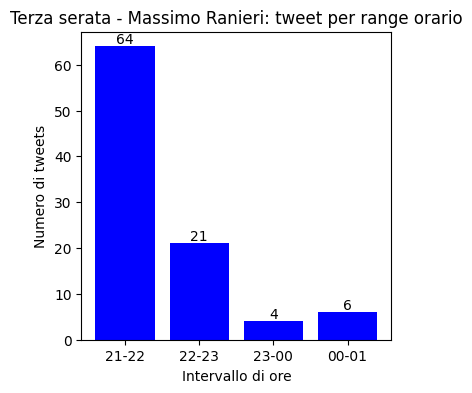

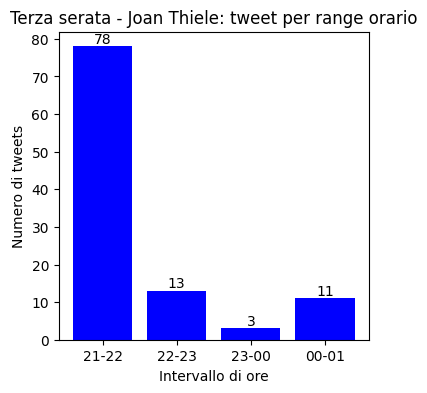

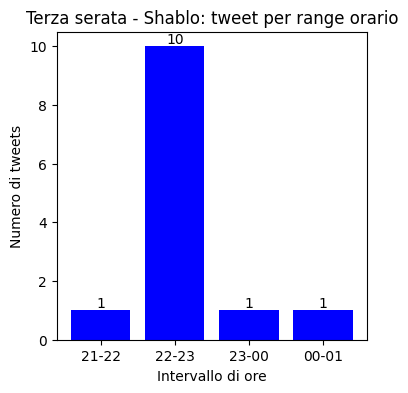

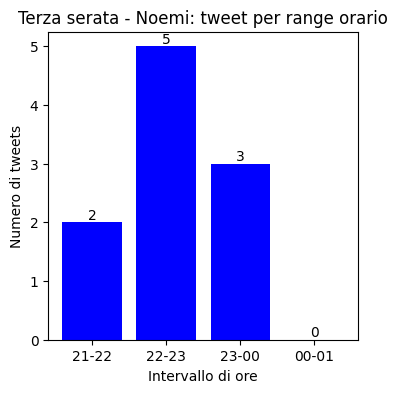

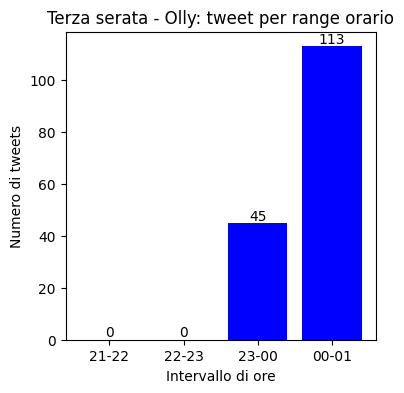

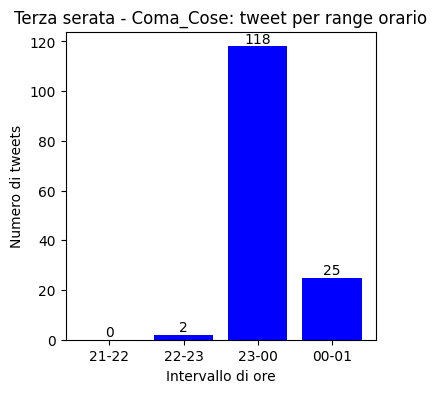

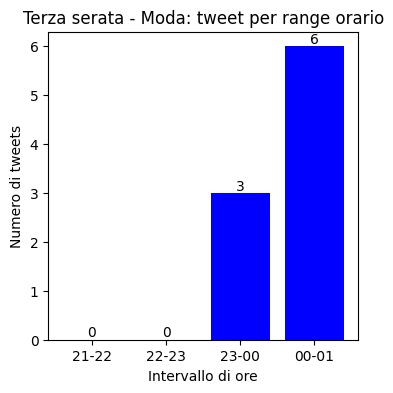

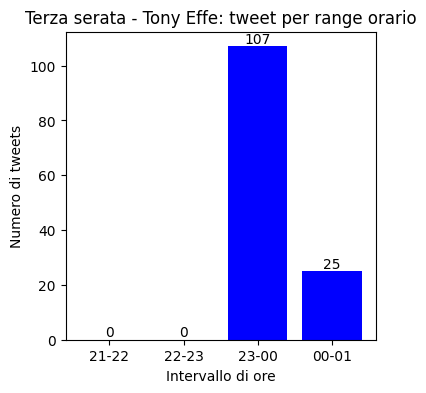

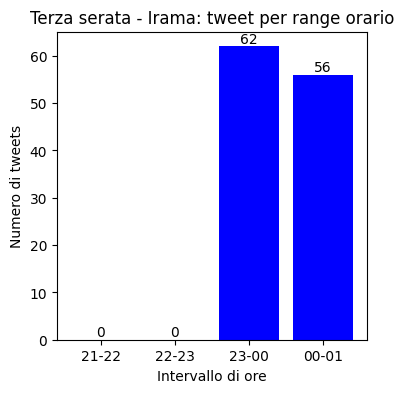

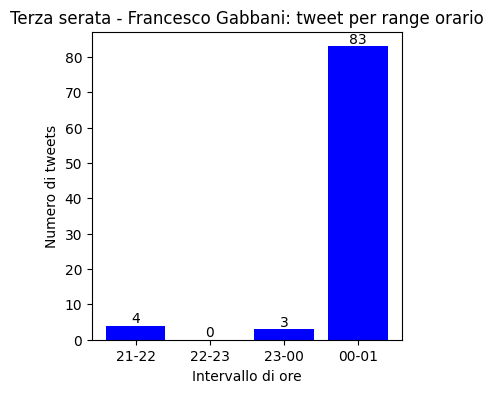

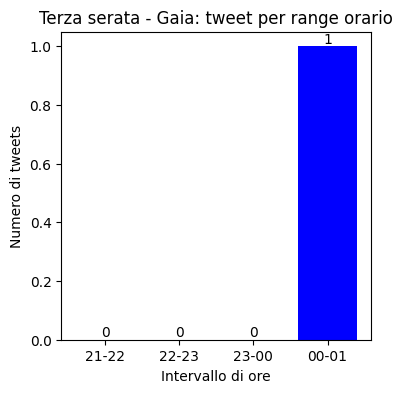

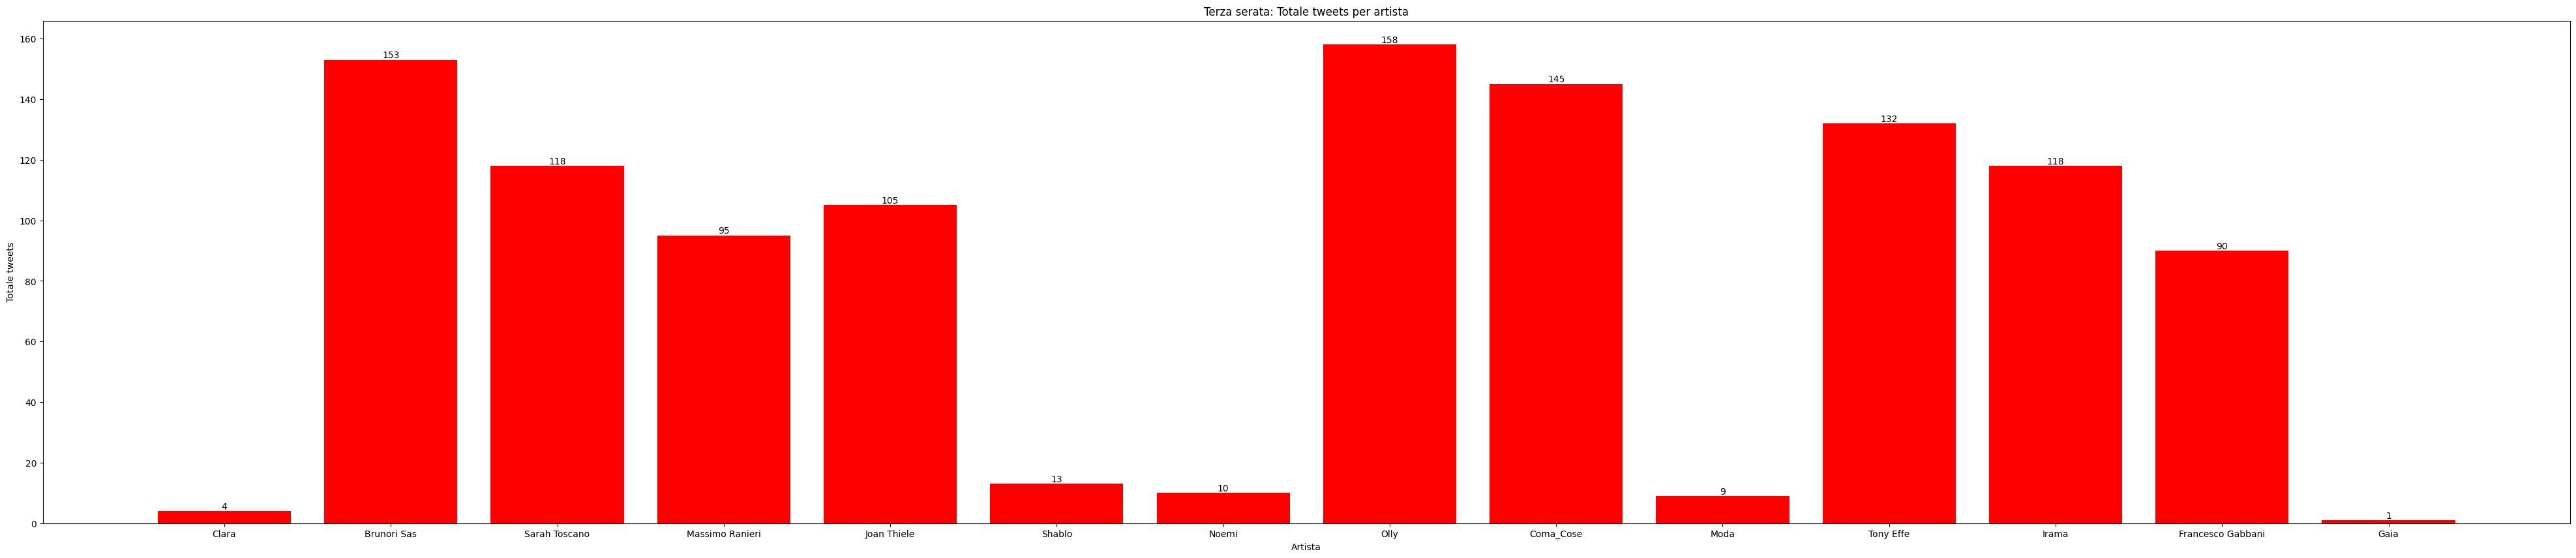

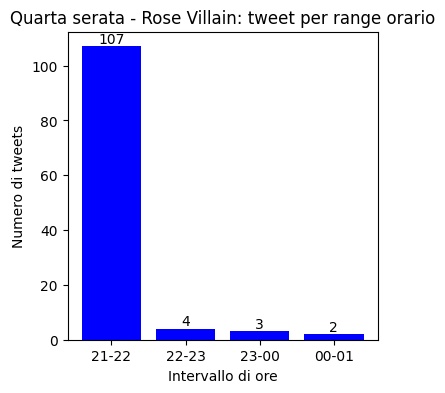

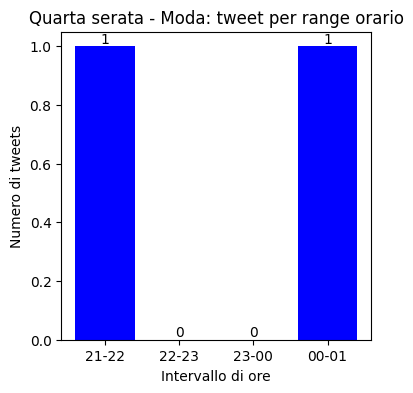

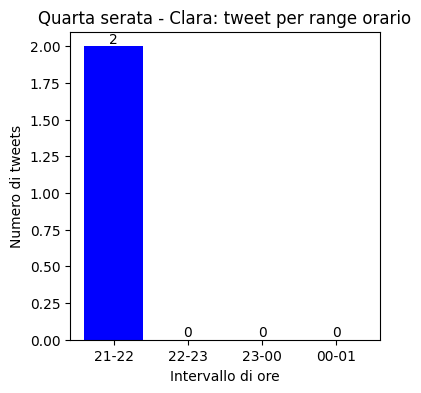

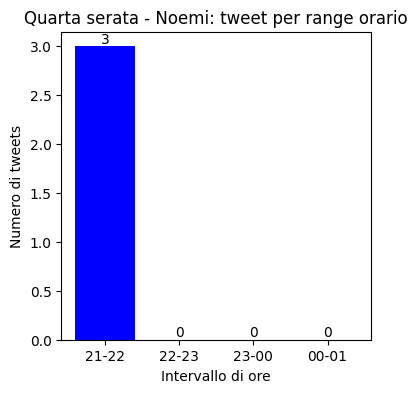

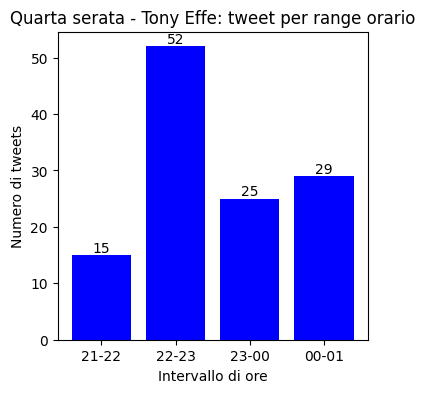

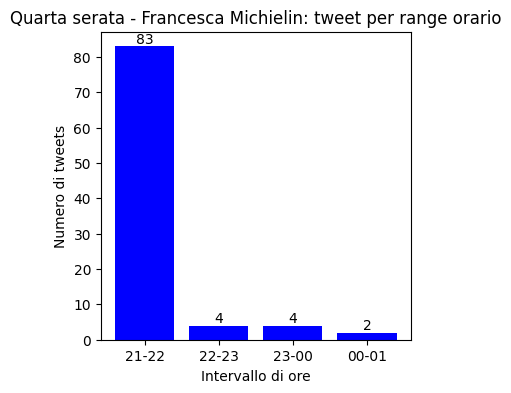

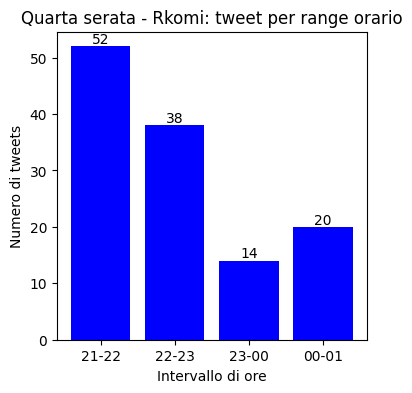

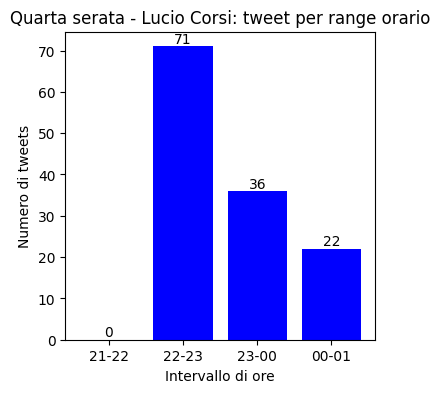

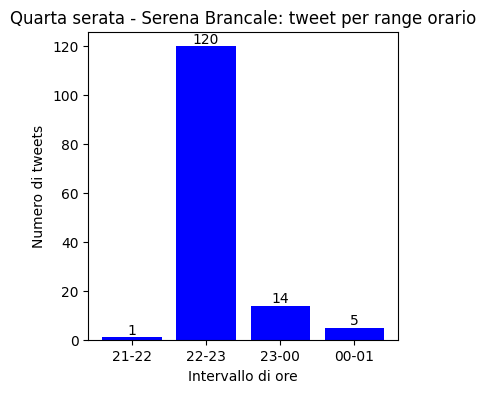

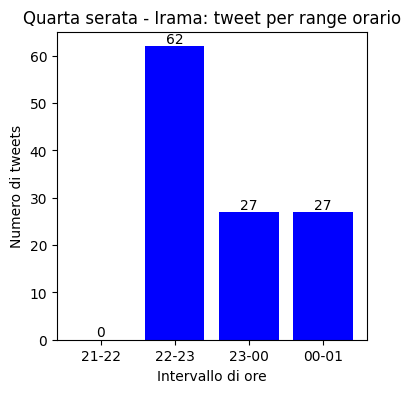

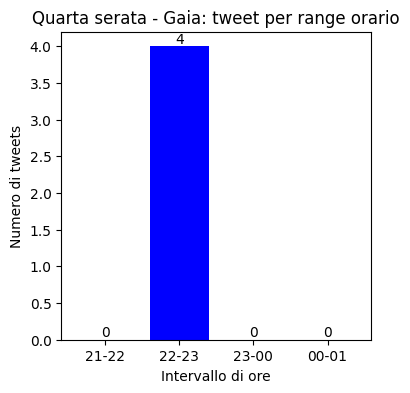

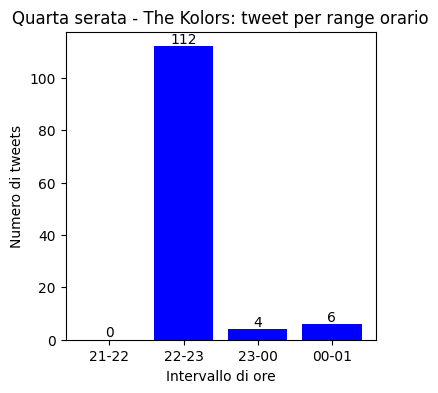

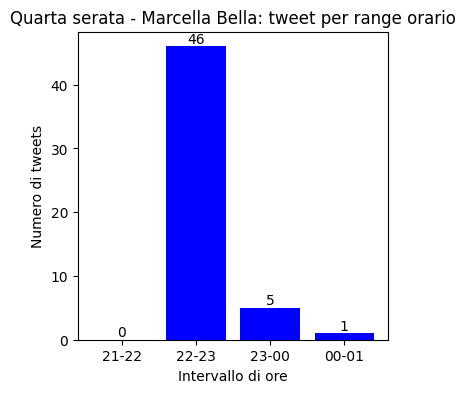

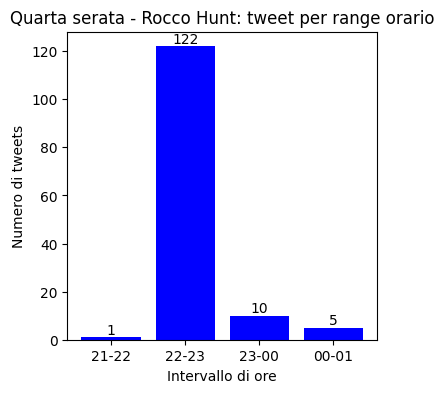

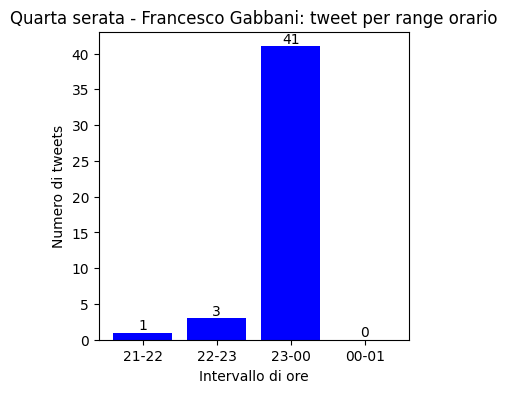

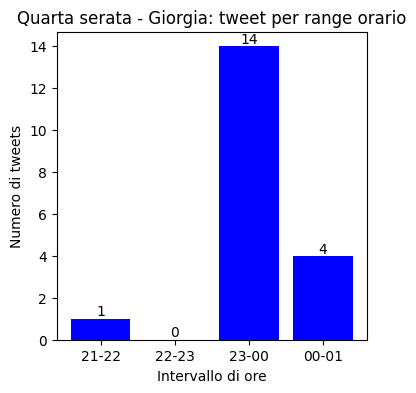

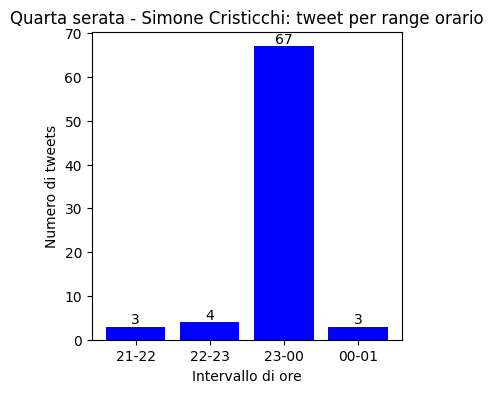

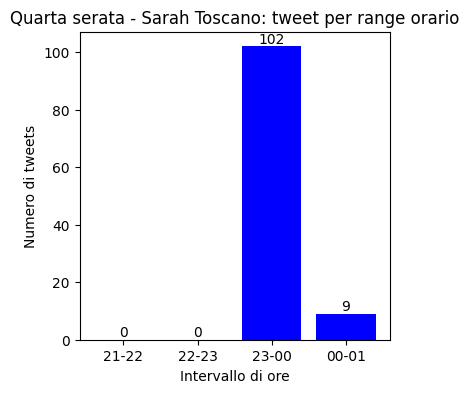

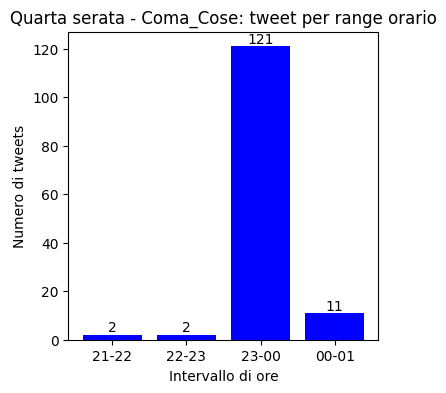

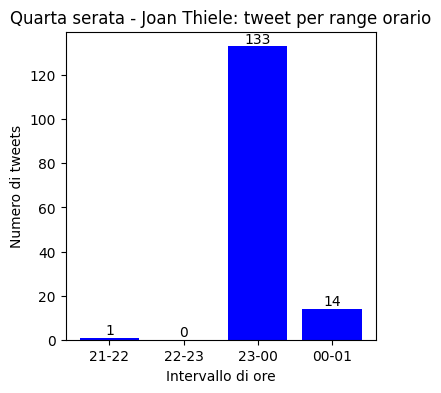

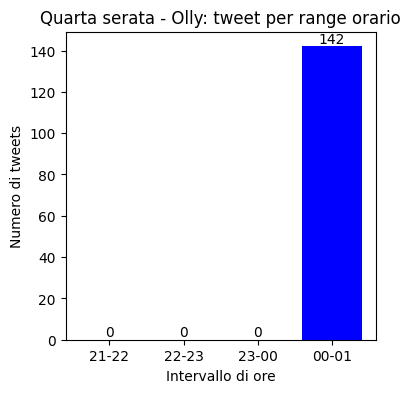

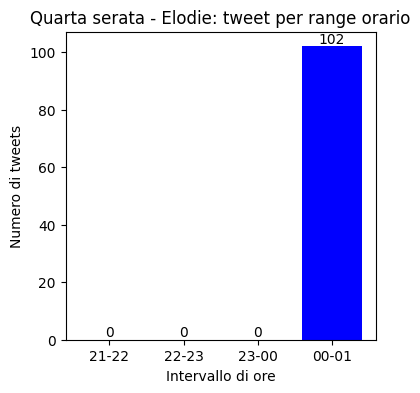

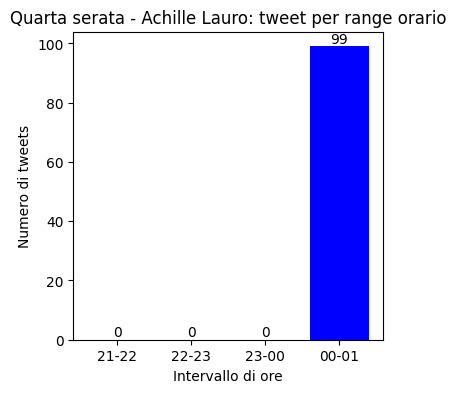

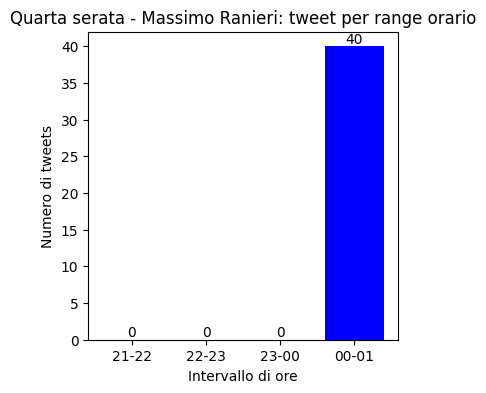

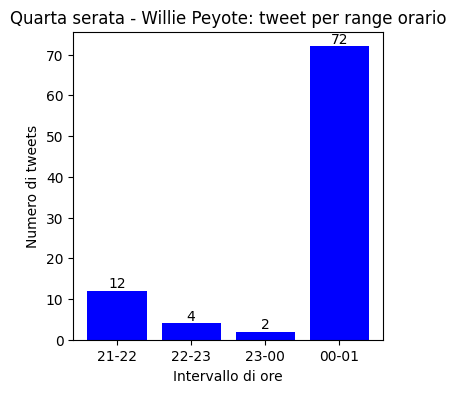

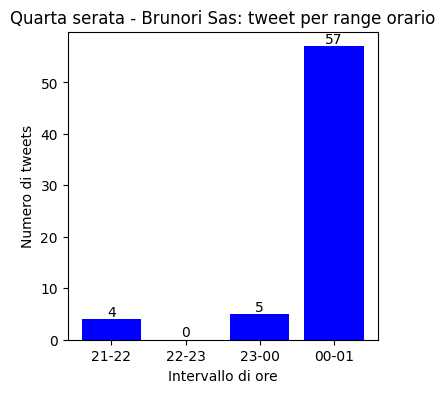

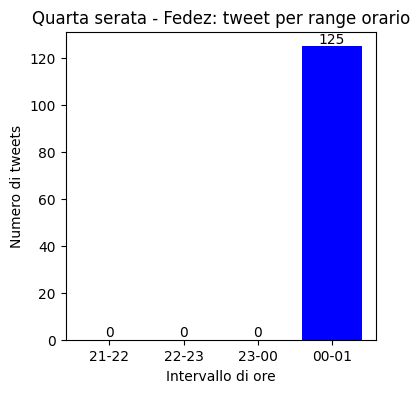

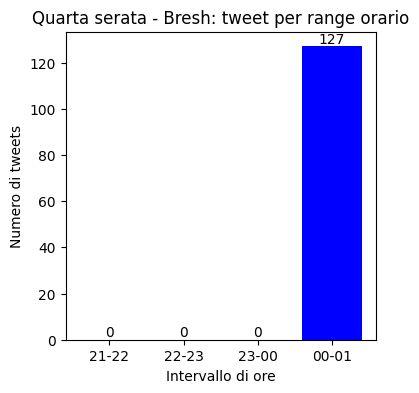

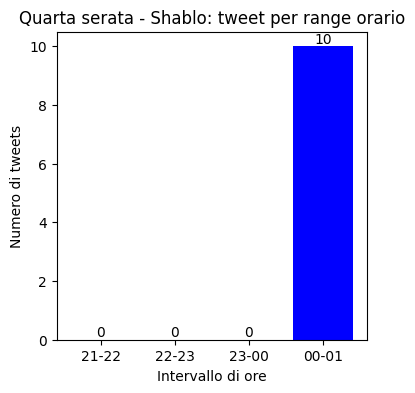

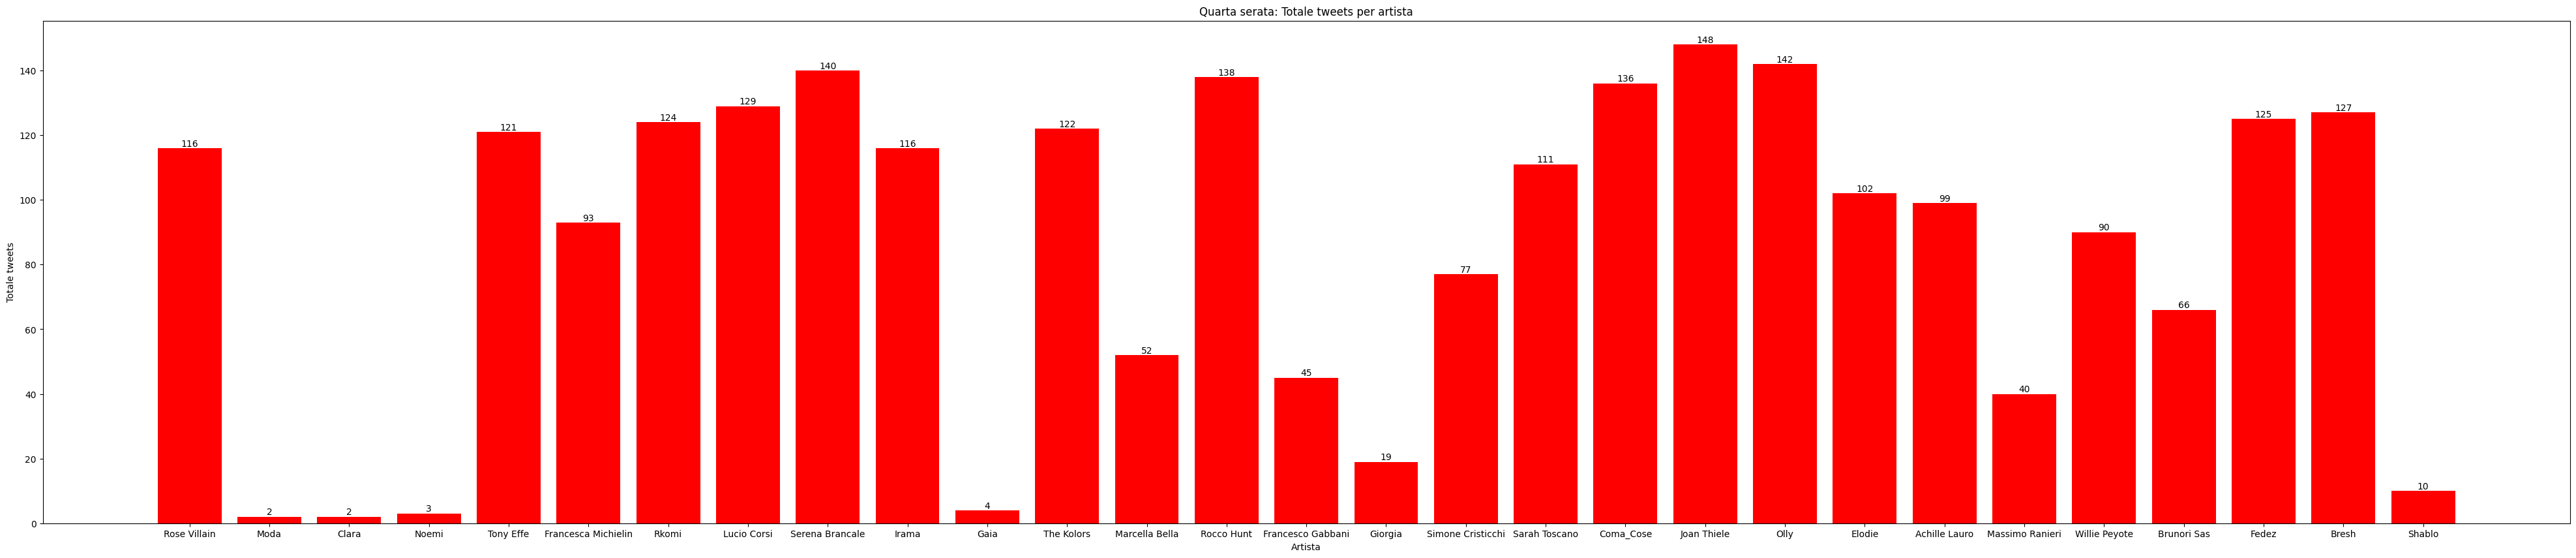

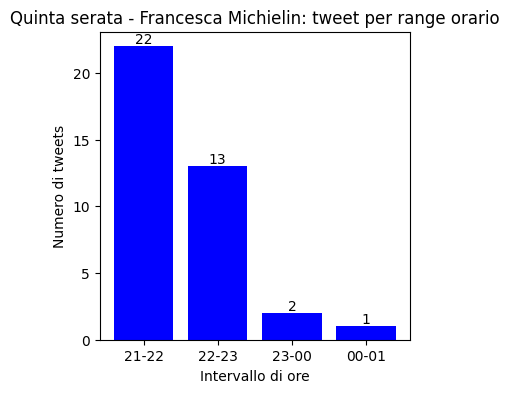

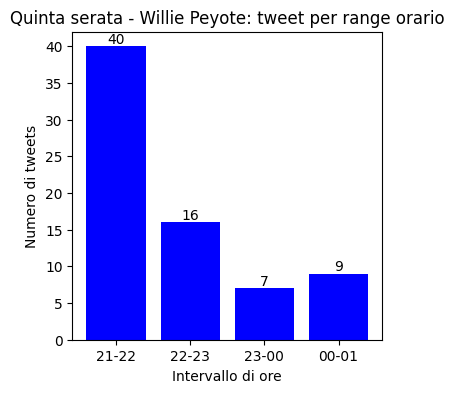

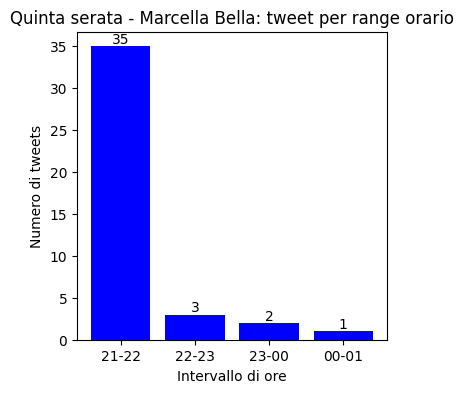

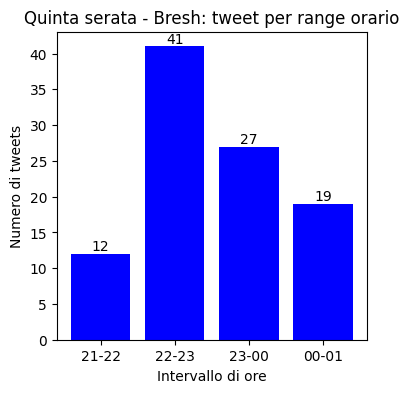

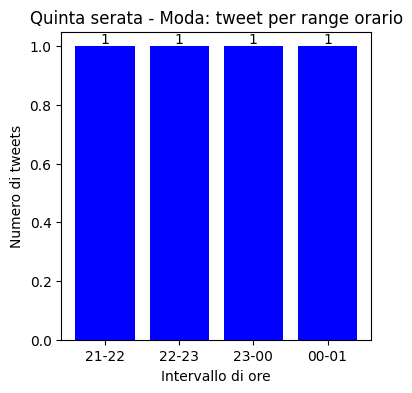

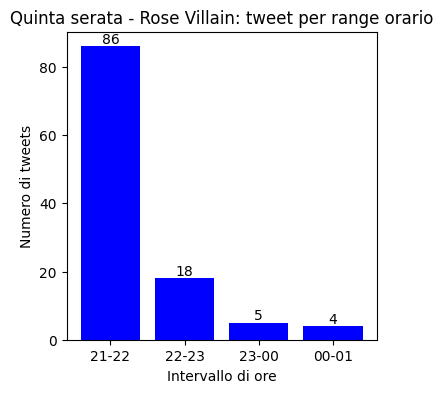

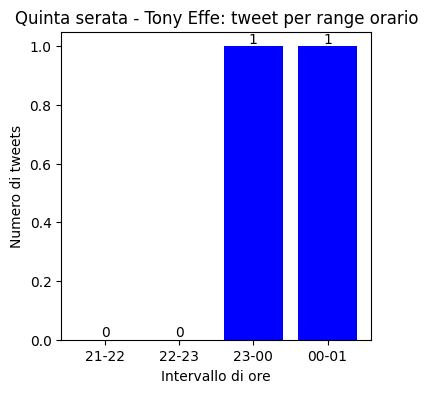

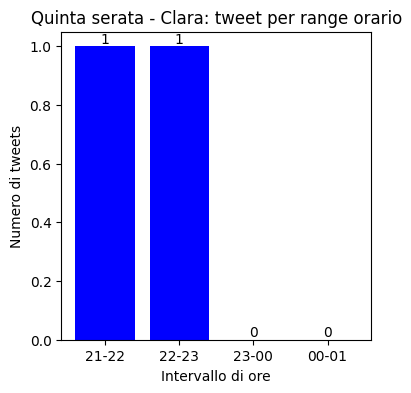

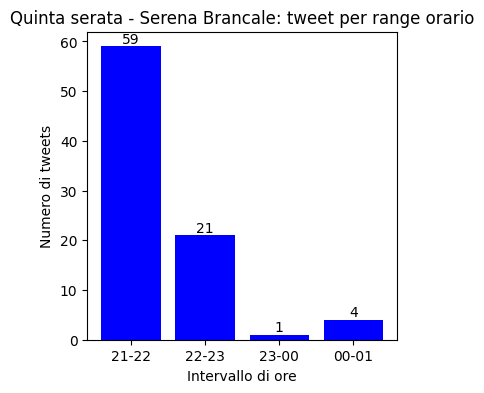

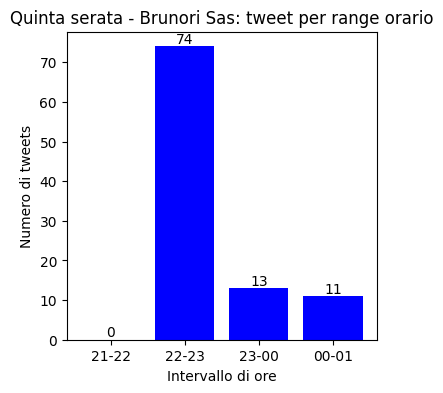

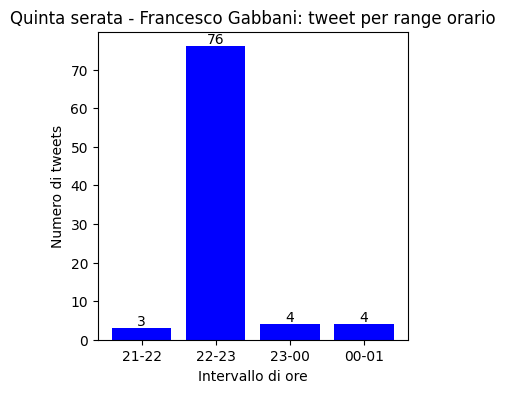

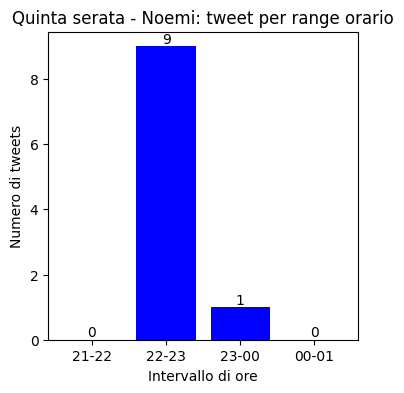

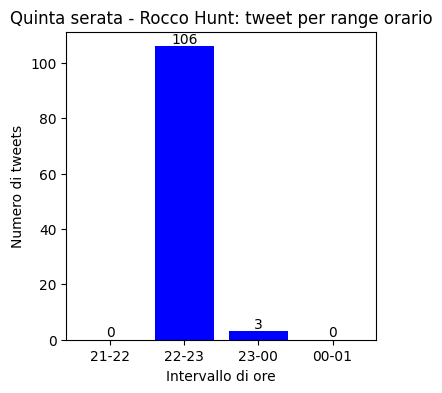

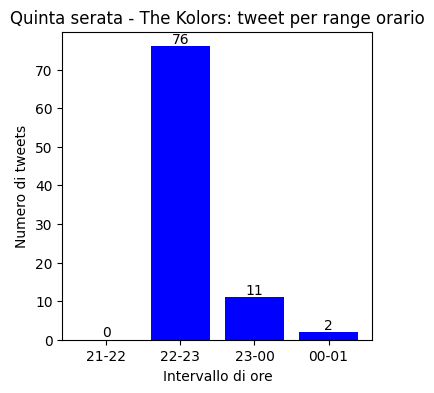

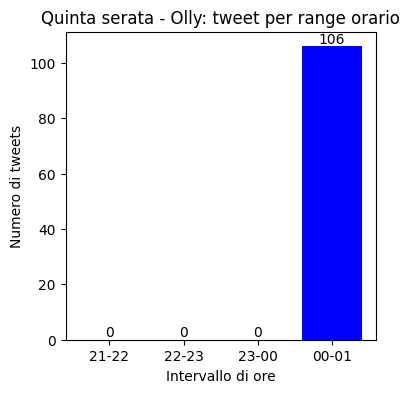

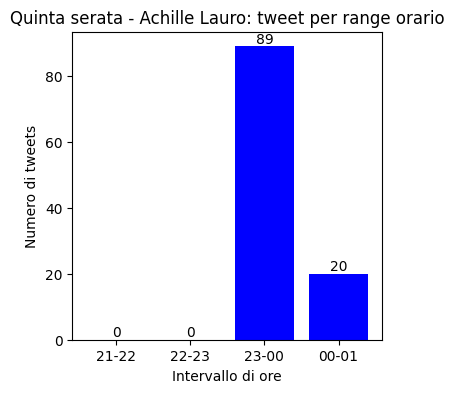

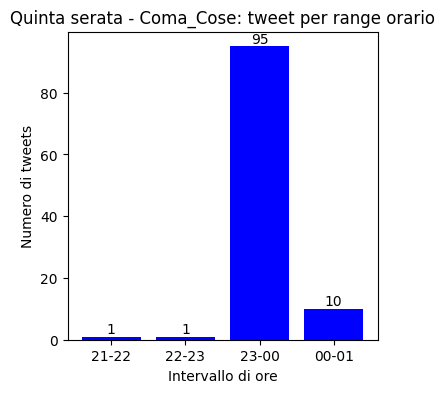

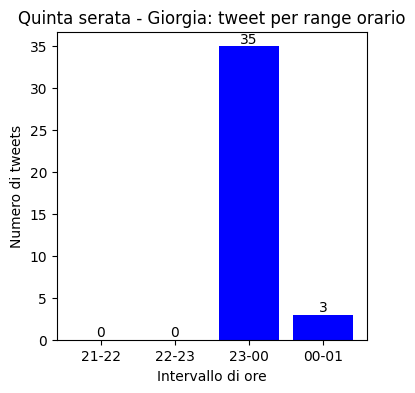

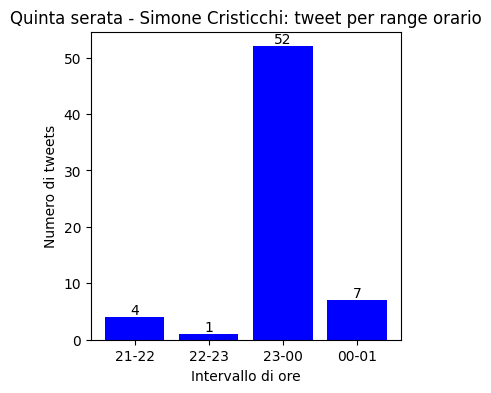

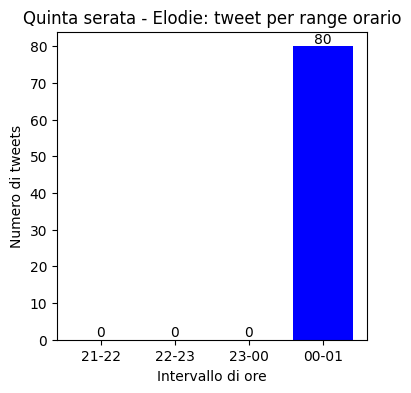

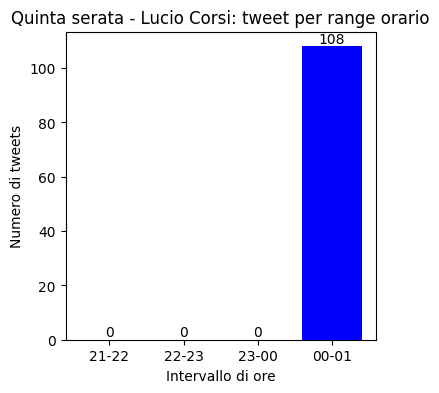

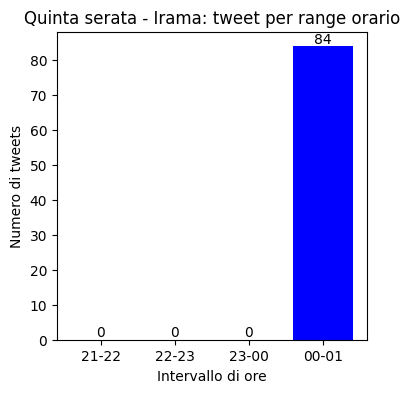

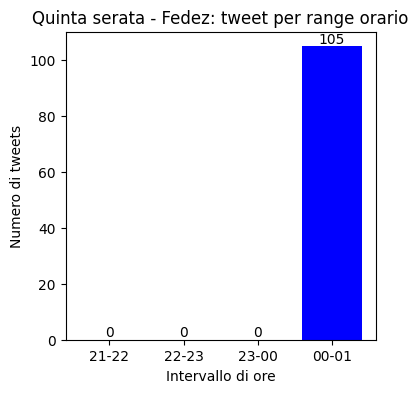

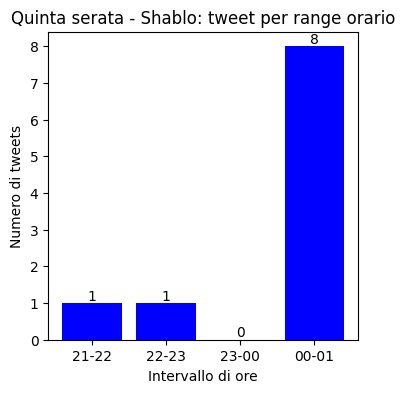

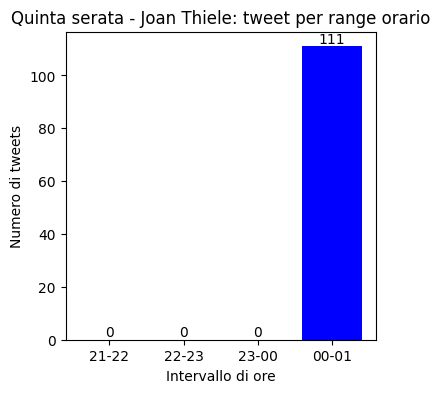

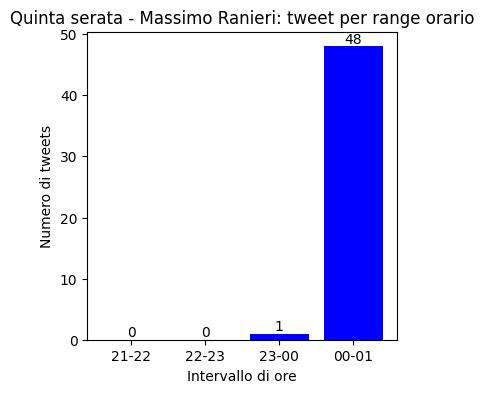

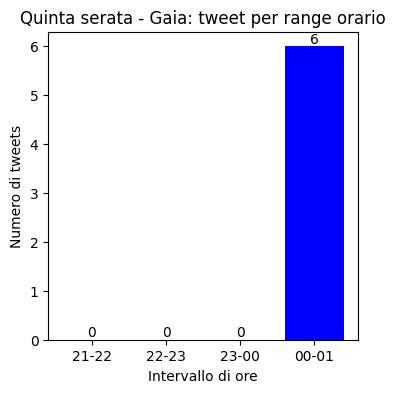

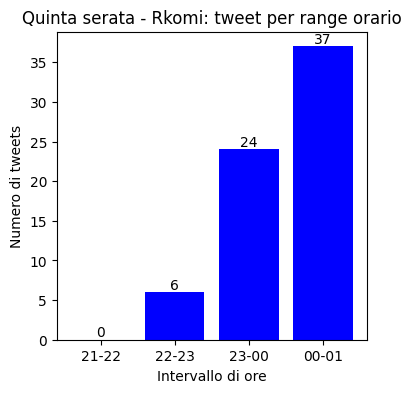

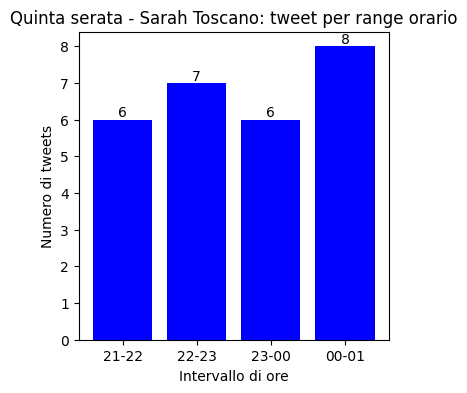

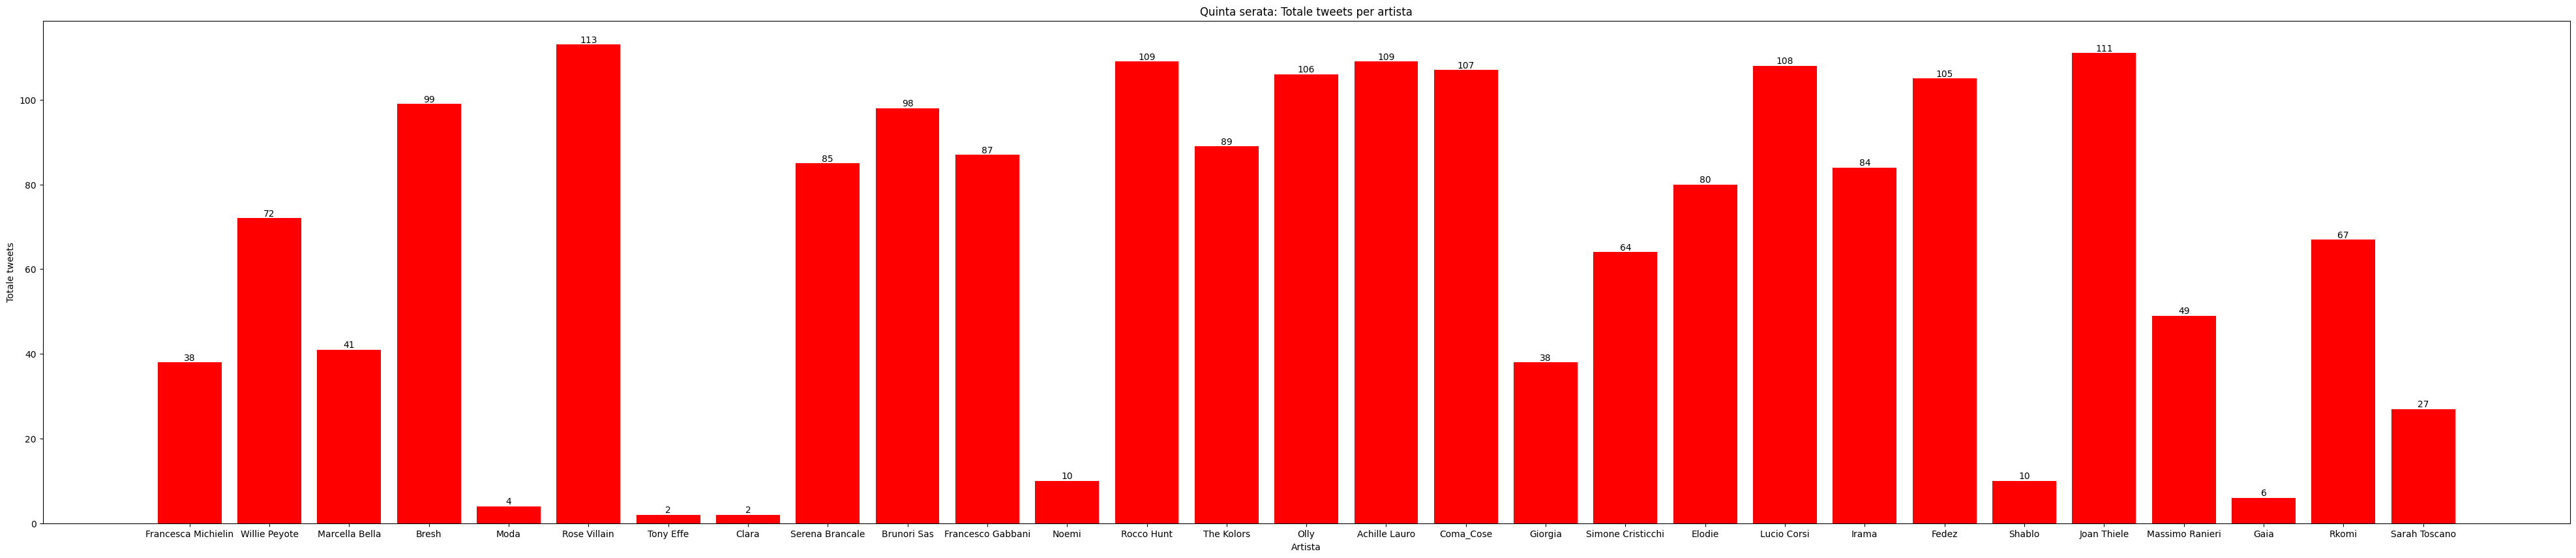

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import os
from constants import SANREMO, HOUR_RANGES, NEXT_DAY_RANGES
from datetime import datetime, timedelta


for night_name, night_info in SANREMO["NIGHTS"].items():
    artists = night_info["scaletta"]
    night_folder = night_name.replace(" ", "_")

    # Dictionary to save the total number of tweets per artist
    artist_totals = {}

    # Plot each artist (hour ranges breakdown)
    for artist in artists:
        counts = []  # List to store tweet counts for each hour range
        artist_folder = os.path.join(night_folder, artist.replace(" ", "_"))
        total_tweets = 0

        for hour_range in HOUR_RANGES:
            # Determine the filename based on the hour range
            if hour_range in NEXT_DAY_RANGES:
                # If the hour range is for the next day (00-01), adjust the date
                date_obj = datetime.strptime(night_info["data"], "%Y-%m-%d")
                data_next_hour = date_obj + timedelta(days=1)
                data_next_hour_str = data_next_hour.strftime("%Y-%m-%d")
                filename = f"{data_next_hour_str}_{hour_range}.csv"
            else:
                filename = f"{night_info['data']}_{hour_range}.csv"

            filepath = "scraped_data" + "/" + os.path.join(artist_folder, filename)
            if os.path.exists(filepath):
                data = pd.read_csv(filepath)
                tweet_count = len(data)
            else:
                tweet_count = 0
            counts.append(tweet_count)
            total_tweets += tweet_count

        artist_totals[artist] = total_tweets

        # Bar plot for the artist
        plt.figure(figsize=(4, 4))
        plt.bar(HOUR_RANGES, counts, color="blue")
        plt.xlabel("Intervallo di ore")
        plt.ylabel("Numero di tweets")
        artist_name = artist.replace("Sanremo", "").strip()
        artist_name = artist_name.replace("Shablo Gue Joshua Tormento", "Shablo")
        plt.title(f"{night_name} - {artist_name}: tweet per range orario")
        # Add the counts on top of the bars
        for i, count in enumerate(counts):
            plt.text(i, count, str(count), ha="center", va="bottom")
        plt.show()

    # Combined bar plot for all artists: total tweets per artist
    plt.figure(figsize=(50, 10))
    artist_names = list(artist_totals.keys())
    artist_names = [
        a.replace("Shablo Gue Joshua Tormento", "Shablo").strip() for a in artist_names
    ]
    # Remove "Sanremo" from artist names
    artist_names = [a.replace("Sanremo", "").strip() for a in artist_names]
    totals = list(artist_totals.values())
    plt.bar(artist_names, totals, color="red")
    plt.xlabel("Artista")
    plt.ylabel("Totale tweets")
    plt.title(f"{night_name}: Totale tweets per artista")
    for i, total in enumerate(totals):
        plt.text(i, total, str(total), ha="center", va="bottom")

    # Save plot
    os.makedirs("scraped_data/plot", exist_ok=True)
    plt.savefig(f"scraped_data/plot/{night_folder}_totals.png")
    plt.show()